(sec:pyalf-custom-obs)=
# Custom/Derived Observables

The previous section showed how to use the observables defined directly in the ALF simulation, but one often needs quantities derived from these. pyALF offers a convenient way for getting results for such derived observables, including a way to check for warmup and autocorrelation issues (more on the latter in the next section).

As usual, we start with some imports:

In [1]:
# Enable Matplotlib Jupyter Widget Backend
%matplotlib widget

import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Numerical libary

from py_alf.ana import load_res  # Function for loading analysis results
from py_alf.analysis import analysis  # Analysis function
from py_alf.utils import find_sim_dirs  # Function for finding QMC bins

In [2]:
# Change some Matplotlib defaults for nicer figures
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [5, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["xtick.direction"] = 'in'
mpl.rcParams["ytick.direction"] = 'in'
mpl.rcParams["xtick.top"] = True
mpl.rcParams["ytick.right"] = True
mpl.rcParams["figure.constrained_layout.use"] = True

Create list with directories to analyze:

In [3]:
dirs = find_sim_dirs()
dirs

['./ALF_data/Hubbard',
 './ALF_data/Hubbard_L1=4_L2=4_U=1.0',
 './ALF_data/Hubbard_L1=4_L2=4_U=2.0',
 './ALF_data/Hubbard_L1=4_L2=4_U=3.0',
 './ALF_data/Hubbard_L1=4_L2=4_U=4.0',
 './ALF_data/Hubbard_Square',
 './ALF_data/temper_Hubbard_L1=4_L2=4_U=2.5/Temp_0',
 './ALF_data/temper_Hubbard_L1=4_L2=4_U=2.5/Temp_1']

The custom observables are defined in a Python dictionary, where the keys are the names of the new observables. The value is another dictionary in the format:

```python
{'needs': some_list,
 'function': some_function,
 'kwargs': some_dict,}
```

Where `some_list` is a list of observable names, this can be any combination of scalar, equal-time, or time-displaced observables. They are being read by {class}`py_alf.ana.ReadObs`. These Jackknife bins as well as *kwargs* from `some_dict` are handed to `some_function` with a separate call for each bin. Currently, only scalars and 1d arrays are supported as return value of `some_function`. We go through some examples to make this procedure clearer.

We start with an empty dictionary, which will hold all the custom observable definitions:

In [4]:
custom_obs = {}

The first custom observable will just be the square of the energy. For this, we define a function taking three arguments, which correspond to one jackknifed bin from {func}`py_alf.ana.read_scal`: 

* `obs`: Array of observable values
* `sign`: Float
* `N_obs`: Length of `obs`, in this case 1.

The next step is to add an entry to `custom_obs`. The name of the new observable shall be *E_squared*. It needs the observable *Ener_scal*, the function defined previously, and we don't hand over any keyword arguments.

In [5]:
def obs_squared(obs, sign, N_obs):
    """Square of a scalar observable.

    obs.shape = (N_obs,)
    """
    return obs[0]**2 / sign

# Energy squared
custom_obs['E_squared']= {
    'needs': ['Ener_scal'],
    'function': obs_squared,
    'kwargs': {}
}

Another custom observable shall be the potential energy divided by kinetic energy. The approach is similar to before, except that this now uses two observables *Pot_scal* and *Kin_scal*:

In [6]:
def E_pot_kin(E_pot_obs, E_pot_sign, E_pot_N_obs,
              E_kin_obs, E_kin_sign, E_kin_N_obs):
    """Ratio of two scalar observables, first observable divided by second."""
    return E_pot_obs/E_kin_obs / (E_pot_sign/E_kin_sign)

# Potential Energy / Kinetic Energy
custom_obs['E_pot_kin']= {
    'needs': ['Pot_scal', 'Kin_scal'],
    'function': E_pot_kin,
    'kwargs': {}
}

Finally, we want to calculate some correlation ratios. A correlation ratio is a renormalisation group invariant quantity, that can be a powerful tool for identifying ordered phases and phase transitions. It is defined as:

\begin{align}
R(O, \boldsymbol{k}_*) = 1 - \frac{O(\boldsymbol{k}_*+\boldsymbol{\delta})}{O(\boldsymbol{k}_*)}
\end{align}

Where $O(\boldsymbol{k})$ is a correlation function that has a divergence at $\boldsymbol{k} = \boldsymbol{k}_*$ in the ordered phase and $\boldsymbol{\delta}$ scales with $1/L$, where $L$ is the linear system size. A usual choice for $\boldsymbol{\delta}$ is the smallest $\boldsymbol{k}$ on the finite-sized Bravais lattice. With these properties, $R(O, \boldsymbol{k}_*)$ will take only one of two values in the thermodynamic limit: 0 in the unordered phase and 1 in the ordered phase.

The above can be generalized, to an average over multiple singular points $\boldsymbol{k}_i$ and distances from those points $\boldsymbol{\delta}_j$, which results in:

\begin{align}
R &= \frac{1}{N_k} \sum_{i=1}^{N_k} 
      \left(
        1 - \frac{\frac{1}{N_\delta} \sum_{j=1}^{N_\delta} O(\boldsymbol{k}_i+\boldsymbol{\delta}_j)}{O(\boldsymbol{k}_i)} 
      \right)
\end{align}

Furthermore, the correlation function might have an orbital structure to be considered:
\begin{align}
O(\boldsymbol{k}) &= \sum_{n, m} \tilde{O}(\boldsymbol{k})_{n, m} M_{n, m}
\end{align}

All in all, this can be expressed in a function like this:

In [7]:
def R_k(obs, back, sign, N_orb, N_tau, dtau, latt,
        ks=((0., 0.),), mat=None, NNs=((1, 0), (0, 1), (-1, 0), (0, -1))):
    """Calculate correlation ratio, an RG-invariant quantity derived from
    a correlation function.

    Parameters
    ----------
    obs : array of shape (N_orb, N_orb, N_tau, latt.N)
        Correlation function, the background is already subtracted.
    back : array of shape (N_orb,)
        Background of Correlation function.
    sign : float
        Monte Carlo sign.
    N_orb : int
        Number of orbitals per unit cell.
    N_tau : int
        Number of imaginary time slices. 1 for equal-time correlations.
    dtau : float
        Imaginary time step.
    latt : py_alf.Lattice
        Bravais lattice object.
    ks : list of k-points, default=((0., 0.),)
        Singular points of the correlation function in the intended order.
    mat : array of shape (N_orb, N_orb), default=None
        Orbital structure of the order parameter. Default: Trace over orbitals.
    NNs : list of tuples, default=((1, 0), (0, 1), (-1, 0), (0, -1))
        Deltas in terms of primitive k-vectors of the Bravais lattice.

    """
    if mat is None:
        mat = np.identity(N_orb)
    out = 0
    for k in ks:
        n = latt.k_to_n(k)

        J1 = (obs[..., n].sum(axis=-1) * mat).sum()
        J2 = 0
        for NN in NNs:
            i = latt.nnlistk[n, NN[0], NN[1]]
            J2 += (obs[..., i].sum(axis=-1) * mat).sum() / len(NNs)
        out += (1 - J2/J1)

    return out / len(ks)

This function works for both equal-time and time-displaced correlations. The first 7 arguments (`obs, back, sign, N_orb, N_tau, dtau, latt`) are supplied by {func}`analysis() <py_alf.analysis>` if a correlation function is requested in *needs*. The optional keyword arguments specify the singular $\boldsymbol{k}$ points, the orbital structure and $\boldsymbol{\delta}_j$ to be considered.

Correlation ratios for ferromagnetic and antiferromagnetic order can now be defined with:

In [8]:
# RG-invariant quantity for ferromagnetic order
custom_obs['R_Ferro']= {
    'needs': ['SpinT_eq'],
    'function': R_k,
    'kwargs': {'ks': [(0., 0.)]}
}

# RG-invariant quantity for antiferromagnetic order
custom_obs['R_AFM']= {
    'needs': ['SpinT_eq'],
    'function': R_k,
    'kwargs': {'ks': [(np.pi, np.pi)]}
}

In [9]:
def obs_k(obs, back, sign, N_orb, N_tau, dtau, latt,
          ks=((0., 0.),), mat=None):
    """Mean of correlation function at one, or multiple k-points.

    Calculates integral over tau (=susceptibility) if time-displaced
    correlation is supplied.

    Parameters
    ----------
    obs : array of shape (N_orb, N_orb, N_tau, latt.N)
        Correlation function, the background is already subtracted.
    back : array of shape (N_orb,)
        Background of Correlation function.
    sign : float
        Monte Carlo sign.
    N_orb : int
        Number of orbitals per unit cell.
    N_tau : int
        Number of imaginary time slices. 1 for equal-time correlations.
    dtau : float
        Imaginary time step.
    latt : py_alf.Lattice
        Bravais lattice object.
    ks : list of k-points, default=[(0., 0.)]
    mat : array of shape (N_orb, N_orb), default=None
        Orbital structure. Default: Trace over orbitals.

    """
    if mat is None:
        mat = np.identity(N_orb)
    out = 0
    for k in ks:
        n = latt.k_to_n(k)

        if N_tau == 1:
            out += (obs[:, :, 0, n] * mat).sum()
        else:
            out += (obs[..., n].sum(axis=-1) * mat).sum()*dtau

    return out / len(ks)

# Correlation of Spin z-component at k=(pi, pi)
custom_obs['SpinZ_pipi']= {
    'needs': ['SpinZ_eq'],
    'function': obs_k,
    'kwargs': {'ks': [(np.pi, np.pi)]}
}

# Correlation of Spin x+y-component at k=(pi, pi)
custom_obs['SpinXY_pipi']= {
    'needs': ['SpinXY_eq'],
    'function': obs_k,
    'kwargs': {'ks': [(np.pi, np.pi)]}
}

# Correlation of total Spin at k=(pi, pi)
custom_obs['SpinXYZ_pipi']= {
    'needs': ['SpinT_eq'],
    'function': obs_k,
    'kwargs': {'ks': [(np.pi, np.pi)]}
}

The same definitions for `custom_obs` are also written in the local file `custom_obs.py` to be used in further sections.

To now analyze with these custom observables, the dictionary has to be handed over as a keyword argument to {func}`analysis() <py_alf.analysis>`.
The analysis skips a directory by default if the QMC bins file `data.h5` and the parameter file `parameters` are both older than `res.pkl`, which is the case since `res.pkl` has been freshly created in the previous section. Therefore, we use the option `always=True` to overwrite this behavior.

In [10]:
for directory in dirs:
    analysis(directory, custom_obs=custom_obs, always=True)

### Analyzing ./ALF_data/Hubbard ###
/home/jonas/Programs/pyALF/doc/source/usage
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinT_eq']


custom R_AFM ['SpinT_eq']
custom SpinZ_pipi ['SpinZ_eq']
custom SpinXY_pipi ['SpinXY_eq']
custom SpinXYZ_pipi ['SpinT_eq']
Scalar observables:
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing ./ALF_data/Hubbard_L1=4_L2=4_U=1.0 ###
/home/jonas/Programs/pyALF/doc/source/usage
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinT_eq']
custom R_AFM ['SpinT_eq']
custom SpinZ_pipi ['SpinZ_eq']
custom SpinXY_pipi ['SpinXY_eq']
custom SpinXYZ_pipi ['SpinT_eq']
Scalar observables:
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq


SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing ./ALF_data/Hubbard_L1=4_L2=4_U=2.0 ###
/home/jonas/Programs/pyALF/doc/source/usage
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinT_eq']
custom R_AFM ['SpinT_eq']
custom SpinZ_pipi ['SpinZ_eq']
custom SpinXY_pipi ['SpinXY_eq']
custom SpinXYZ_pipi ['SpinT_eq']
Scalar observables:
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing ./ALF_data/Hubbard_L1=4_L2=4_U=3.0 ###
/home/jonas/Programs/pyALF/doc/source/usage
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinT_eq']
custom R_AFM ['SpinT_eq']
custom SpinZ_pipi ['SpinZ_eq']
custom SpinXY_pipi ['SpinXY_eq']


custom SpinXYZ_pipi ['SpinT_eq']
Scalar observables:
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing ./ALF_data/Hubbard_L1=4_L2=4_U=4.0 ###
/home/jonas/Programs/pyALF/doc/source/usage
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinT_eq']
custom R_AFM ['SpinT_eq']
custom SpinZ_pipi ['SpinZ_eq']
custom SpinXY_pipi ['SpinXY_eq']
custom SpinXYZ_pipi ['SpinT_eq']
Scalar observables:
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing ./ALF_data/Hubbard_Square ###
/home/jonas/Programs/pyALF/doc/source/usage
Custom observables:
custom E_squared ['Ener_scal']


custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinT_eq']
custom R_AFM ['SpinT_eq']
custom SpinZ_pipi ['SpinZ_eq']
custom SpinXY_pipi ['SpinXY_eq']
custom SpinXYZ_pipi ['SpinT_eq']
Scalar observables:
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing ./ALF_data/temper_Hubbard_L1=4_L2=4_U=2.5/Temp_0 ###
/home/jonas/Programs/pyALF/doc/source/usage
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinT_eq']
custom R_AFM ['SpinT_eq']


custom SpinZ_pipi ['SpinZ_eq']
custom SpinXY_pipi ['SpinXY_eq']
custom SpinXYZ_pipi ['SpinT_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing ./ALF_data/temper_Hubbard_L1=4_L2=4_U=2.5/Temp_1 ###
/home/jonas/Programs/pyALF/doc/source/usage
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinT_eq']
custom R_AFM ['SpinT_eq']
custom SpinZ_pipi ['SpinZ_eq']
custom SpinXY_pipi ['SpinXY_eq']
custom SpinXYZ_pipi ['SpinT_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau


The results are loaded the same way as in the previous section:

In [11]:
res = load_res(dirs)

./ALF_data/Hubbard
No orbital locations saved.
./ALF_data/Hubbard_L1=4_L2=4_U=1.0
No orbital locations saved.
./ALF_data/Hubbard_L1=4_L2=4_U=2.0
No orbital locations saved.
./ALF_data/Hubbard_L1=4_L2=4_U=3.0
No orbital locations saved.
./ALF_data/Hubbard_L1=4_L2=4_U=4.0
No orbital locations saved.
./ALF_data/Hubbard_Square
No orbital locations saved.
./ALF_data/temper_Hubbard_L1=4_L2=4_U=2.5/Temp_0
No orbital locations saved.
./ALF_data/temper_Hubbard_L1=4_L2=4_U=2.5/Temp_1
No orbital locations saved.


Access to the values is analogues to scalar observables:

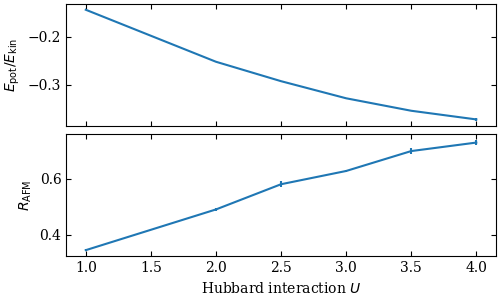

In [12]:
# Create figure with two axes and axis labels
fig, (ax1, ax2) = plt.subplots(2, 1,
                               sharex=True,
                               constrained_layout=True)
ax1.set_ylabel(r'$E_{\rm pot} / E_{\rm kin}$')
ax2.set_ylabel(r'$R_{\rm AFM}$')
ax2.set_xlabel(r'Hubbard interaction $U$')

# Select only rows with l1==4 and sort by ham_u
df = res[res.l1 == 4].sort_values(by='ham_u')

# Plot data
ax1.errorbar(df.ham_u, df.E_pot_kin, df.E_pot_kin_err)
ax2.errorbar(df.ham_u, df.R_AFM, df.R_AFM_err);